In [108]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [109]:
# replace with the actual CSV file path or URL
df = pd.read_csv('data/bug-severity-raw.csv')
df.head()

,ticket_id,submitted_at,product_area,customer_type,priority,reporter_experience,reproduction_steps,num_attachments,description_length,affected_users_count,prev_similar_tickets,module_version,ticket_type,auto_tag_count,sla_breached,assigned_team,severity,resolved_at
0,TCKT-100000,9/29/2023 13:35,Auth,Internal,Medium,Senior,True,1,574.0,13.0,0.0,5.2.11,Bug,5,No,QA,Medium,9/30/2023 19:35
1,TCKT-100001,3/5/2025 6:23,DevOps,Internal,High,Junior,True,0,299.0,16.0,2.0,4.2.4,Question,3,Yes,Dev,Medium,3/6/2025 16:23
2,TCKT-100002,7/25/2023 18:40,ML,SMB,Low,Junior,False,2,526.0,13.0,0.0,3.2.11,Bug,1,No,QA,Low,7/27/2023 2:40
3,TCKT-100003,10/18/2023 22:03,Auth,Free-tier,Low,Mid,True,2,734.0,7.0,0.0,4.8.4,Bug,2,No,QA,Low,10/20/2023 3:03
4,TCKT-100004,6/27/2025 0:35,Backend,Enterprise,medium,Mid,True,1,374.0,7.0,3.0,2.9.15,Bug,3,No,Security,Medium,6/27/2025 7:35


In [110]:
df.shape

(5000, 18)

### Data checks

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ticket_id             5000 non-null   object 
 1   submitted_at          5000 non-null   object 
 2   product_area          5000 non-null   object 
 3   customer_type         5000 non-null   object 
 4   priority              5000 non-null   object 
 5   reporter_experience   5000 non-null   object 
 6   reproduction_steps    5000 non-null   bool   
 7   num_attachments       5000 non-null   int64  
 8   description_length    4750 non-null   float64
 9   affected_users_count  4752 non-null   float64
 10  prev_similar_tickets  4750 non-null   float64
 11  module_version        5000 non-null   object 
 12  ticket_type           5000 non-null   object 
 13  auto_tag_count        5000 non-null   int64  
 14  sla_breached          5000 non-null   object 
 15  assigned_team        

In [112]:
df.describe()

,num_attachments,description_length,affected_users_count,prev_similar_tickets,auto_tag_count
count,5000.000000,4750.000000,4752.000000,4750.000000,5000.000000
mean,1.520600,597.528421,42.457912,1.003158,1.981800
std,3.494742,151.379318,335.242381,0.985786,1.416429
min,0.000000,70.000000,1.000000,0.000000,0.000000
25%,0.000000,494.000000,8.000000,0.000000,1.000000
50%,1.000000,597.000000,10.000000,1.000000,2.000000
75%,2.000000,702.000000,12.000000,2.000000,3.000000
max,48.000000,1153.000000,4932.000000,6.000000,10.000000


### Target Variable Analysis

In [113]:
# Class distribution
print("\nClass Distribution:\n", df['severity'].value_counts())
print ("\nClass percentages:\n", df['severity'].value_counts(normalize=True) * 100)

# Check for class imbalance
class_counts = df['severity'].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 1.5:
    print("The dataset is imbalanced.")



Class Distribution:
 severity
Medium      2030
Low         1617
High         803
Critical     549
critical       1
Name: count, dtype: int64

Class percentages:
 severity
Medium      40.60
Low         32.34
High        16.06
Critical    10.98
critical     0.02
Name: proportion, dtype: float64

Imbalance Ratio: 2030.00
The dataset is imbalanced.


### Missing Data Analysis


Missing Values Summary:
                                     Column  Missing Values  Percentage
description_length      description_length             250        5.00
affected_users_count  affected_users_count             248        4.96
prev_similar_tickets  prev_similar_tickets             250        5.00


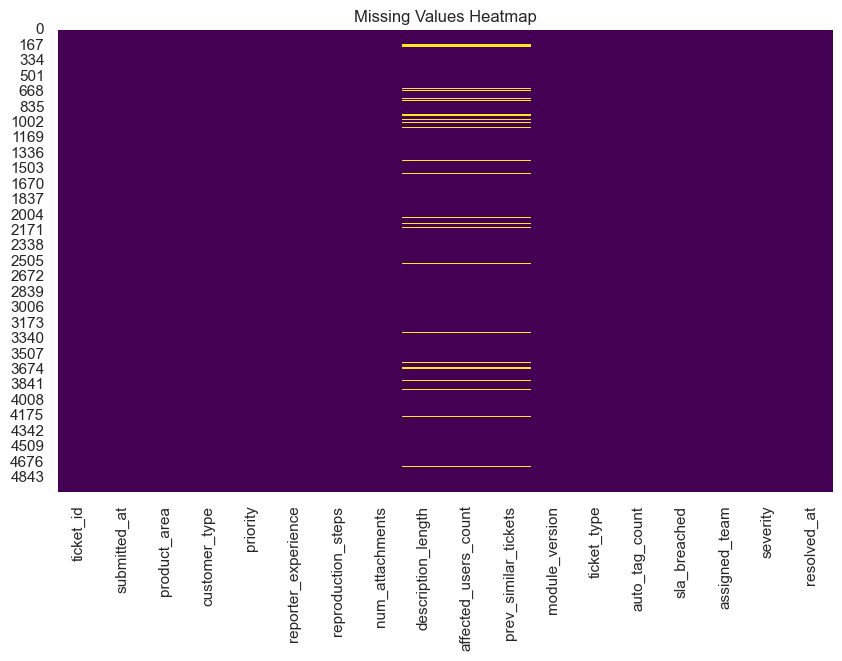

In [114]:
# Calculate missing values
missing_values = pd.DataFrame({
    'Column': df.columns,
    'Missing Values': df.isnull().sum().values,
    'Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_values = missing_values[missing_values['Missing Values'] > 0]
print("\nMissing Values Summary:\n", missing_values)

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [115]:
# Fix the Missing Values 
df['description_length'].fillna(df['description_length'].mean(), inplace=True)
df['affected_users_count'].fillna(df['affected_users_count'].median(), inplace=True)
df['prev_similar_tickets'].fillna(df['prev_similar_tickets'].mean(), inplace=True)
df.isnull().sum()  # Verify no missing values remain

ticket_id               0
submitted_at            0
product_area            0
customer_type           0
priority                0
reporter_experience     0
reproduction_steps      0
num_attachments         0
description_length      0
affected_users_count    0
prev_similar_tickets    0
module_version          0
ticket_type             0
auto_tag_count          0
sla_breached            0
assigned_team           0
severity                0
resolved_at             0
dtype: int64

### Data Types Checks and Corrections

In [116]:
# Convert datetime columns
date_columns = ['submitted_at', 'resolved_at']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    print(f"{col} converted to datetime.")

# Convert boolean columns
df['reproduction_steps'] = df['reproduction_steps'].map({'True': 1, 'False': 0, True: 1, False: 0})
df['sla_breached'] = df['sla_breached'].map({'Yes': 1, 'No': 0})
print("Boolean columns converted to numeric.")

# Ensure numeric columns are correctly typed
numeric_columns = ['num_attachments','description_length', 'affected_users_count', 'prev_similar_tickets', 'auto_tag_count']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
print("Numeric columns are in their correct data type.")

# Check for parsing errors
print(f"\n Datetime parsing errors: {df[date_columns].isnull().sum().sum()}")
print(f"\n Numeric parsing errors: {df[numeric_columns].isnull().sum().sum()}")

submitted_at converted to datetime.
resolved_at converted to datetime.
Boolean columns converted to numeric.
Numeric columns are in their correct data type.

 Datetime parsing errors: 0

 Numeric parsing errors: 0


### Data Quality Checks

In [117]:
# Check for duplicate tickets
duplicates = df.duplicated(subset=['ticket_id']).sum()
print(f"\nNumber of duplicate tickets: {duplicates}")
if duplicates > 0:
    df.drop_duplicates(subset=['ticket_id'], inplace=True)
    print("Duplicates removed.")
    df = df.drop_duplicates(subset=['ticket_id'], keep='first')

# Check for date logic errors
df['resolution_time'] = (df['resolved_at'] - df['submitted_at']).dt.total_seconds() / 3600 # in hours
invalid_resolution = (df['resolution_time'] < 0).sum()
print(f"\nNumber of tickets with invalid resolution times: {invalid_resolution}")
if invalid_resolution > 0:
    df = df[df['resolution_time'] >= 0]
print("Invalid resolution times removed.")

# Check for future dates
future_dates = (df['submitted_at'] > pd.Timestamp.now()).sum()
print(f"\nNumber of tickets with future submission dates: {future_dates}")

# Check numerical columns for imposible values
for col in numeric_columns:
    negative_values = (df[col] < 0).sum()
    print(f"Number of negative values in {col}: {negative_values}")
    if negative_values > 0:
        df = df[df[col] >= 0]
        print(f" {col} negative values removed.")

# Check for categorical consistency
categorical_columns = ['product_area', 'customer_type', 'priority', 'reporter_experience', 'ticket_type', 'assigned_team', 'severity']
for col in categorical_columns:
    unique_values = df[col].unique()
    print(f"\nUnique values in {col}: {unique_values}")


Number of duplicate tickets: 0

Number of tickets with invalid resolution times: 25
Invalid resolution times removed.

Number of tickets with future submission dates: 0
Number of negative values in num_attachments: 0
Number of negative values in description_length: 0
Number of negative values in affected_users_count: 0
Number of negative values in prev_similar_tickets: 0
Number of negative values in auto_tag_count: 0

Unique values in product_area: ['Auth' 'DevOps' 'ML' 'Backend' 'Security' 'API' 'Database' 'UI']

Unique values in customer_type: ['Internal' 'SMB' 'Free-tier' 'Enterprise' 'smb']

Unique values in priority: ['Medium' 'High' 'Low' 'medium' 'Urgent' 'urgent' 'high']

Unique values in reporter_experience: ['Senior' 'Junior' 'Mid' 'mid' 'senior' 'junior']

Unique values in ticket_type: ['Bug' 'Question' 'crash' 'Crash' 'Performance' 'Feature Request' 'bug']

Unique values in assigned_team: ['QA' 'Dev' 'Security' 'SRE' 'Support' 'support']

Unique values in severity: ['Mediu

In [118]:
# Apply title case to categorical columns to remove the inconsistencies
for col in categorical_columns:
    df[col] = df[col].str.title()
# Confirm changes
    unique_values = df[col].unique()
    print(f"\nUnique values in {col} after cleaning: {unique_values}")


Unique values in product_area after cleaning: ['Auth' 'Devops' 'Ml' 'Backend' 'Security' 'Api' 'Database' 'Ui']

Unique values in customer_type after cleaning: ['Internal' 'Smb' 'Free-Tier' 'Enterprise']

Unique values in priority after cleaning: ['Medium' 'High' 'Low' 'Urgent']

Unique values in reporter_experience after cleaning: ['Senior' 'Junior' 'Mid']

Unique values in ticket_type after cleaning: ['Bug' 'Question' 'Crash' 'Performance' 'Feature Request']

Unique values in assigned_team after cleaning: ['Qa' 'Dev' 'Security' 'Sre' 'Support']

Unique values in severity after cleaning: ['Medium' 'Low' 'High' 'Critical']


### Univariate Analysis Numerical Features

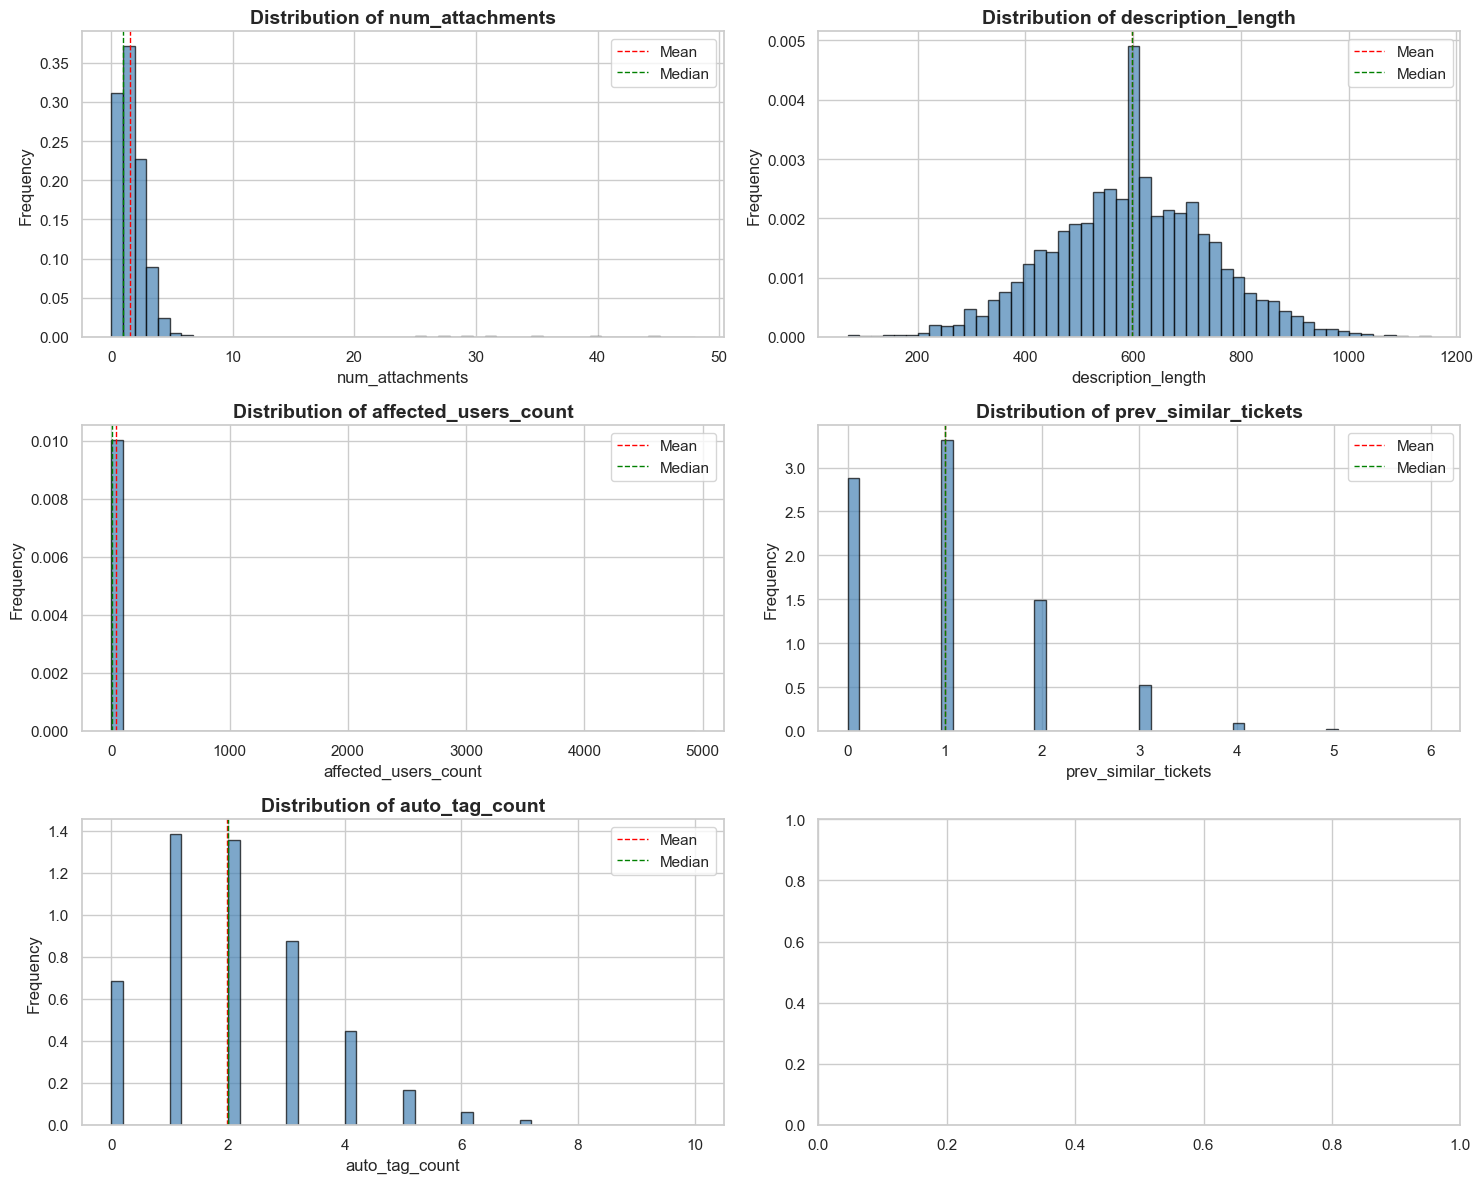


Skewness and Kurtosis:
                 Feature   Skewness    Kurtosis
0       num_attachments   9.132626   94.254551
1    description_length   0.010527    0.145736
2  affected_users_count  11.508873  139.605208
3  prev_similar_tickets   0.924951    0.774608
4        auto_tag_count   0.764381    0.700095

Interpretation:
 Skewness values > 1 or < -1 indicate high skewness (needs transformation)
 Kurtosis values > 3 indicate heavy tails (potential outliers)


In [119]:
# Visualize distributions
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numeric_columns):
    # Histogram
    axes[idx].hist(df[col].dropna(), bins=50, alpha=0.7, color='steelblue', edgecolor='black', density=True)
    axes[idx].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

    # Statistics
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[idx].axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label='Mean')
    axes[idx].axvline(median_val, color='green', linestyle='dashed', linewidth=1, label='Median')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# Skewness and Kurtosis
from scipy.stats import skew, kurtosis

skew_kurtosis = pd.DataFrame({
    'Feature': numeric_columns,
    'Skewness': [skew(df[col].dropna()) for col in numeric_columns],
    'Kurtosis': [kurtosis(df[col].dropna()) for col in numeric_columns]
})
print("\nSkewness and Kurtosis:\n", skew_kurtosis)

print("\nInterpretation:")
print(" Skewness values > 1 or < -1 indicate high skewness (needs transformation)")
print(" Kurtosis values > 3 indicate heavy tails (potential outliers)")

### Outlier Detection

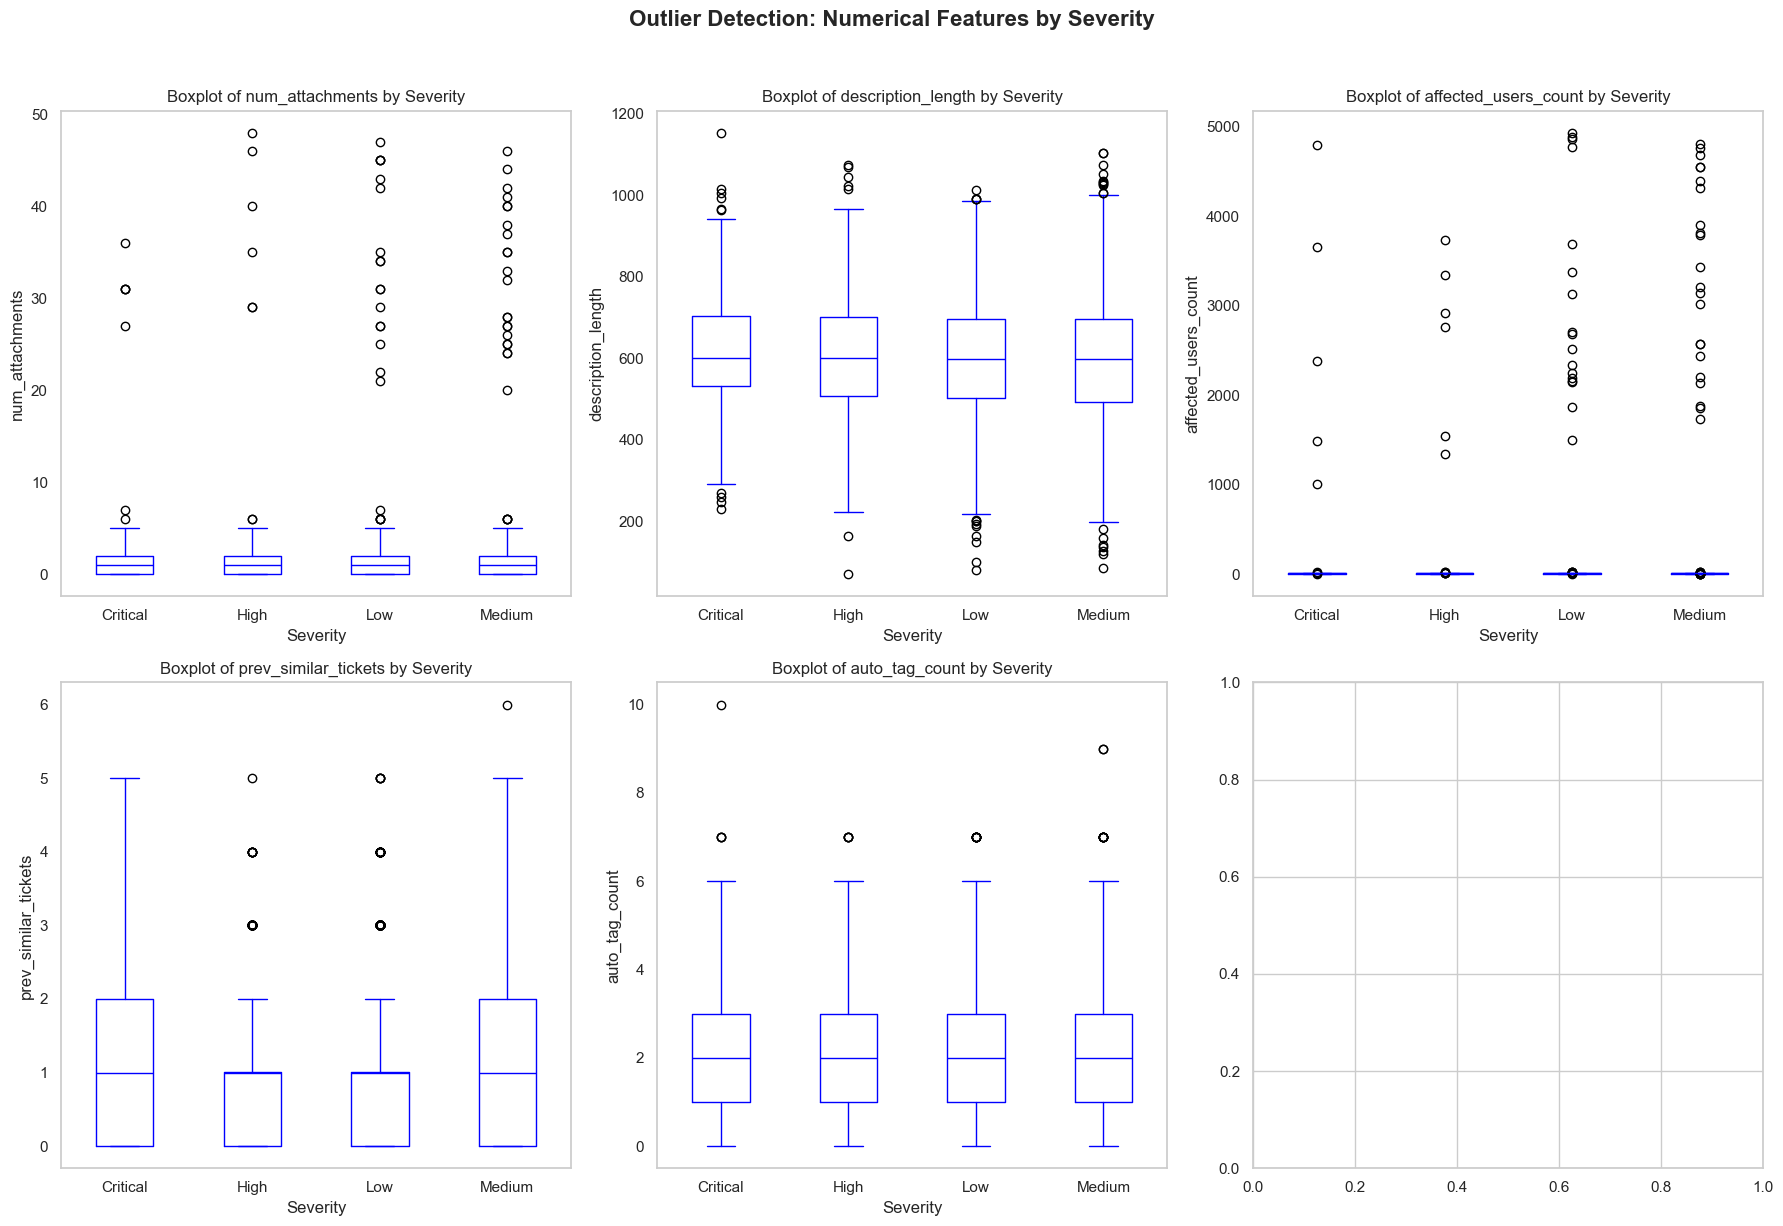

In [120]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Analyze outliers for each numerical feature
outlier_summary = []

for col in numeric_columns:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(df, col)
    outlier_summary.append({
        'Feature': col,
        'Outlier Count': len(outliers),
        'Outlier Percentage': len(outliers) / len(df) * 100,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Min_Outlier_Value': outliers[col].min() if len(outliers) > 0 else None,
        'Max_Outlier_Value': outliers[col].max() if len(outliers) > 0 else None
    })

# Boxplot visualization of outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(numeric_columns):
    df.boxplot(column=col, by='severity', ax=axes[idx], color='blue', grid=False)
    axes[idx].set_title(f'Boxplot of {col} by Severity')
    axes[idx].set_xlabel('Severity')
    axes[idx].set_ylabel(col)

plt.suptitle('Outlier Detection: Numerical Features by Severity', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Univariate Analysis Categorical Features

PRODUCT_AREA
Unique values: 8

Distribution:
product_area
Devops      653
Ml          646
Ui          641
Database    623
Api         611
Backend     604
Auth        600
Security    597
Name: count, dtype: int64

Percentages:
product_area
Devops      13.13
Ml          12.98
Ui          12.88
Database    12.52
Api         12.28
Backend     12.14
Auth        12.06
Security    12.00
Name: count, dtype: float64
CUSTOMER_TYPE
Unique values: 4

Distribution:
customer_type
Enterprise    2001
Smb           1546
Internal       942
Free-Tier      486
Name: count, dtype: int64

Percentages:
customer_type
Enterprise    40.22
Smb           31.08
Internal      18.93
Free-Tier      9.77
Name: count, dtype: float64
PRIORITY
Unique values: 4

Distribution:
priority
Medium    1996
Low       1483
High      1024
Urgent     472
Name: count, dtype: int64

Percentages:
priority
Medium    40.12
Low       29.81
High      20.58
Urgent     9.49
Name: count, dtype: float64
REPORTER_EXPERIENCE
Unique values: 3

Di

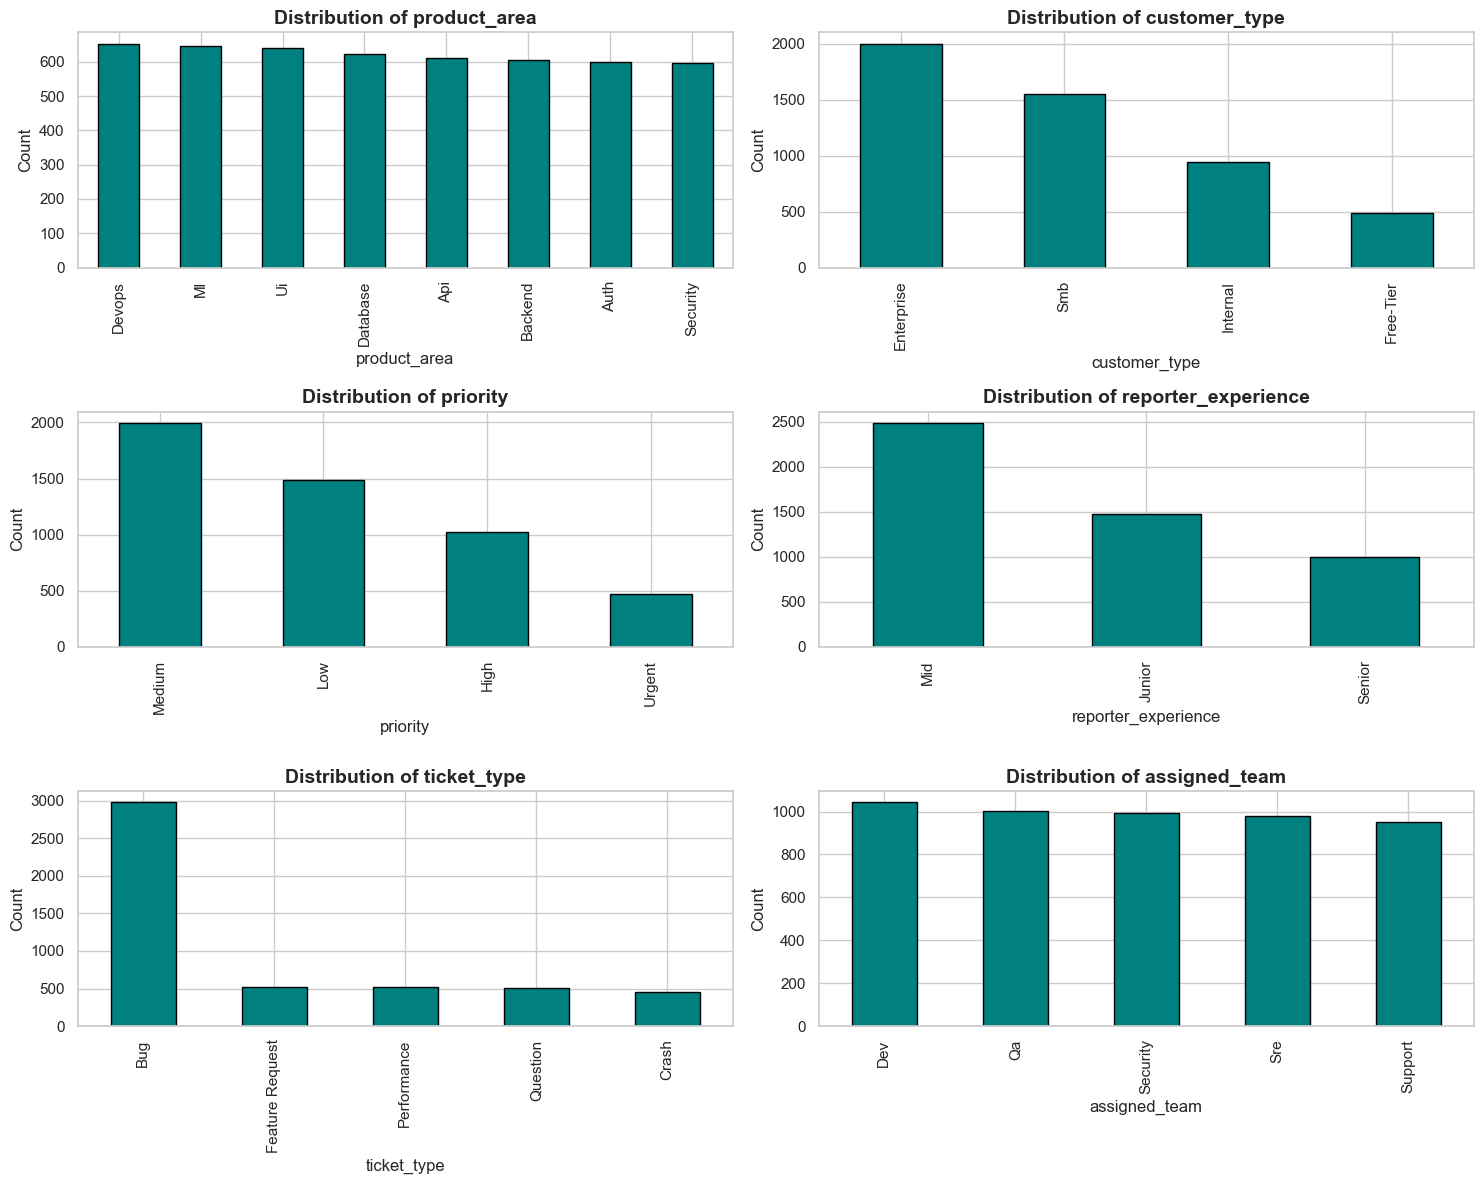

In [122]:
for col in categorical_columns:
    if col == 'severity':
        continue
    print(f"{col.upper()}")

    value_counts = df[col].value_counts()
    print(f"Unique values: {df[col].nunique()}")
    print(f"\nDistribution:")
    print(value_counts)
    print(f"\nPercentages:")
    print((value_counts / len(df) * 100).round(2))

# Visualize categorical distributions
n_cats = len([c for c in categorical_columns if c != 'severity'])
fig, axes = plt.subplots((n_cats + 1) // 2, 2, figsize=(15, 4 *((n_cats + 1) // 2)))
axes = axes.ravel()

idx = 0
for col in categorical_columns:
    if col == 'severity':
        continue
    df[col].value_counts().plot(kind='bar', ax=axes[idx], color='teal', edgecolor='black')
    axes[idx].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    idx += 1

# Remove empty subplots
for j in range(idx, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Bivariate Analysis
#### Numerical Features vs Target

In [126]:
# Statistical tests (ANOVA for numerical vs categorical)
from scipy.stats import f_oneway
from scipy import stats

print("\nANOVA F-statistic (testing if means differ across severity levels):")
for col in numeric_columns:
    groups = [df[df['severity'] == sev][col].dropna() for sev in df['severity'].unique()]
    f_stat, p_val = f_oneway(*groups)
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"{col:30s} | F-stat: {f_stat:8.2f} | p-value: {p_value:.4f} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

# Visualize relationships
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_columns):
    sns.boxplot(x='severity', y=col, data=df, ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'{col} by Severity', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Severity')
    axes[idx].set_ylabel(col)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics by severity
print("Summary Statics by Severity")
    
for col in numeric_columns:
    print(f"\n{col.upper()}")
    print(df.groupby('severity')[col].describe())   



ANOVA F-statistic (testing if means differ across severity levels):


NameError: name 'p_value' is not defined